In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

file_paths = glob.glob("../data/*.gz")

file_paths

['../data/000000000006.csv.gz',
 '../data/000000000014.csv.gz',
 '../data/000000000016.csv.gz',
 '../data/000000000008.csv.gz',
 '../data/000000000004.csv.gz',
 '../data/000000000000.csv.gz',
 '../data/000000000012.csv.gz',
 '../data/000000000010.csv.gz',
 '../data/000000000002.csv.gz',
 '../data/000000000007.csv.gz',
 '../data/000000000015.csv.gz',
 '../data/000000000009.csv.gz',
 '../data/000000000005.csv.gz',
 '../data/000000000001.csv.gz',
 '../data/000000000013.csv.gz',
 '../data/000000000011.csv.gz',
 '../data/000000000003.csv.gz']

In [2]:
df = pd.concat(
    (pd.read_csv(file) for file in file_paths),
    ignore_index=True
)

print(f"Loaded {len(file_paths)} files")
print(f"Total rows: {len(df):,}")

Loaded 17 files
Total rows: 7,293,526


In [3]:
# Preview the dataset.
print(df.head(3))

            user_id  event_date platform install_date   country  \
0  95BEF5B2A45B8C99  2024-02-15  android   2024-02-12   Vietnam   
1  E09661DEA6B80899  2024-02-15  android   2023-09-30  Malaysia   
2  E788F51085AE85B6  2024-02-15  android   2024-02-09   Ukraine   

   total_session_count  total_session_duration  match_start_count  \
0                    1                  70.616                  0   
1                    3                8460.742                 18   
2                    1                   1.417                  0   

   match_end_count  victory_count  defeat_count  server_connection_error  \
0                0              0             0                        0   
1                0              0             0                        0   
2                0              0             0                        0   

   iap_revenue  ad_revenue  
0          0.0    0.000000  
1          0.0    0.035987  
2          0.0    0.000000  


In [4]:
print("Total number of unique users : ", df["user_id"].nunique() )

Total number of unique users :  2453499


# Active Days Distribution

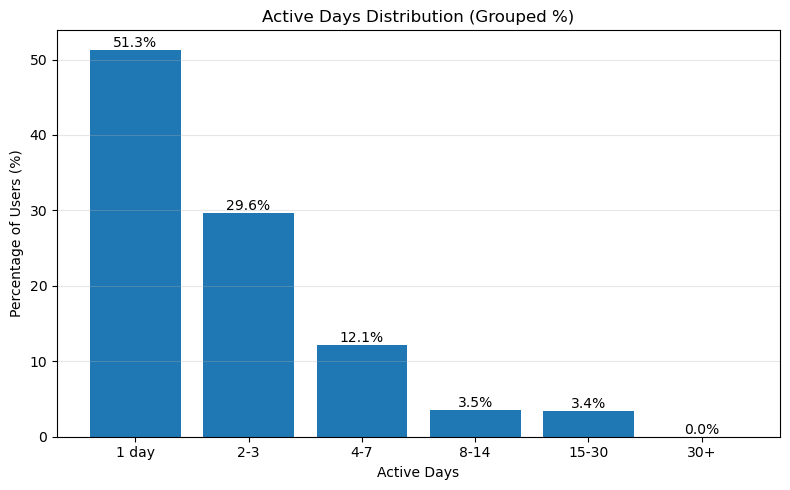

In [5]:
# Count active days per user
user_active_days = (
    df.groupby("user_id")["event_date"]
    .nunique()
)

user_active_days_grouped = pd.cut(
    user_active_days,
    bins=[0,1,3,7,14,30,100],
    labels=["1 day","2-3","4-7","8-14","15-30","30+"]
)

distribution_pct = (
        user_active_days_grouped.value_counts(normalize=True)
        .sort_index()
        * 100
)

plt.figure(figsize=(8,5))

bars = plt.bar(distribution_pct.index, distribution_pct.values)

plt.title("Active Days Distribution (Grouped %)")
plt.xlabel("Active Days")
plt.ylabel("Percentage of Users (%)")
plt.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.1f}%",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

# Retention Analyses

In [6]:
# Ensure datetime
df["event_date"] = pd.to_datetime(df["event_date"])
df["install_date"] = pd.to_datetime(df["install_date"])

# Calculate user age
df["days_since_install"] = (
        df["event_date"] - df["install_date"]
).dt.days

In [7]:
# Define overall cohort (Day 0 users)
cohort_users = df[df["days_since_install"] == 0]["user_id"].unique()
cohort_size = len(cohort_users)

# Compute retention
retention_table = (
    df[df["user_id"].isin(cohort_users)]
    .groupby("days_since_install")["user_id"]
    .nunique()
    .reset_index()
    .rename(columns={"user_id": "active_users"})
)

retention_table["retention_rate"] = (
        retention_table["active_users"] / cohort_size
)

retention_table.head()

,days_since_install,active_users,retention_rate
0,0,1056852,1.000000
1,1,346143,0.327523
2,2,192192,0.181853
3,3,130996,0.123949
4,4,98867,0.093549


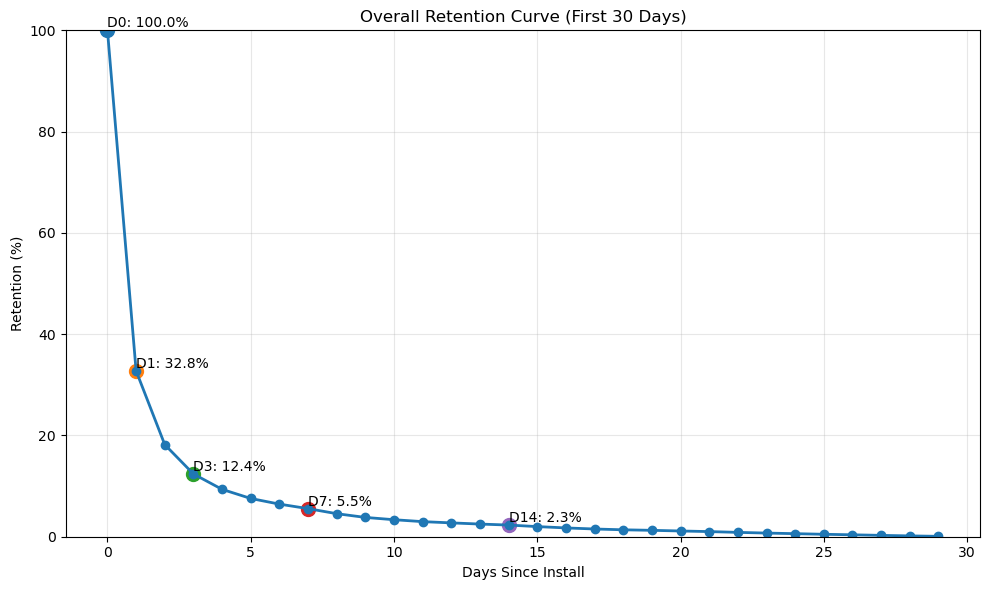

In [8]:
import matplotlib.pyplot as plt

'''
Retention was calculated only for users installed within the data window to avoid lifecycle truncation bias caused by historical installs outside the observation period.
'''
temp_retention = retention_table.copy()

temp_retention = temp_retention[
    temp_retention["days_since_install"] <= 30
    ]

temp_days = temp_retention["days_since_install"]
temp_rates = temp_retention["retention_rate"] * 100

plt.figure(figsize=(10, 6))

plt.plot(
    temp_days,
    temp_rates,
    marker="o",
    linewidth=2
)

highlight_days = [0, 1, 3, 7, 14]

for d in highlight_days:

    temp_row = temp_retention[
        temp_retention["days_since_install"] == d
        ]

    if not temp_row.empty:
        y = temp_row["retention_rate"].values[0] * 100

        plt.scatter(d, y, s=100)
        plt.text(d, y, f"D{d}: {y:.1f}%", va="bottom")

plt.xlabel("Days Since Install")
plt.ylabel("Retention (%)")
plt.title("Overall Retention Curve (First 30 Days)")

plt.ylim(0, 100)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/0q/0c2_61d56959b2w5b9cmvkwr0000gn/T/ipykernel_3179/4071292535.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["platform", "active_group"])


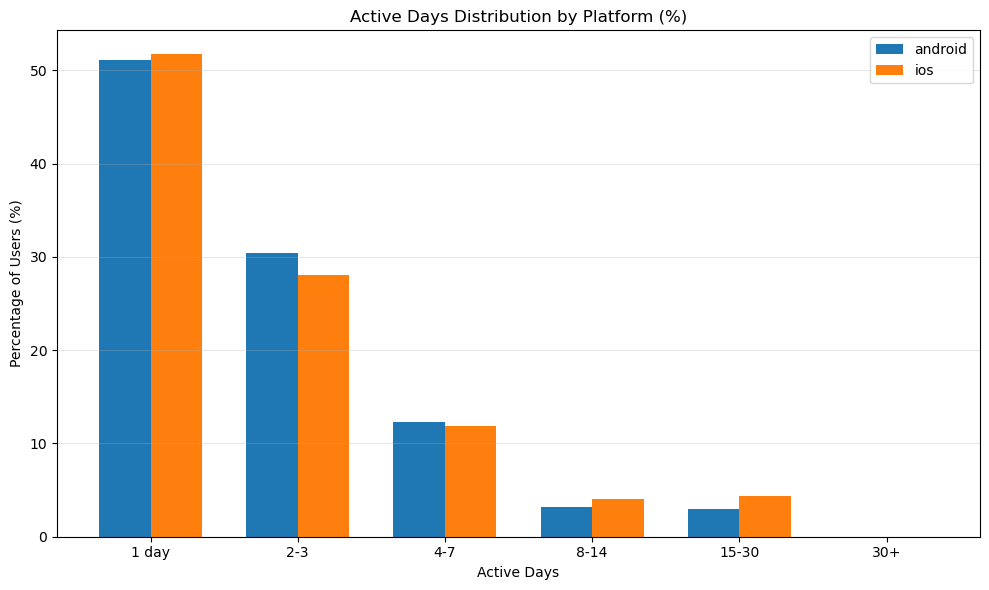

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Active days per user per platform
user_active_days_platform = (
    df.groupby(["platform", "user_id"])["event_date"]
    .nunique()
    .reset_index()
    .rename(columns={"event_date": "active_days"})
)

# Bucket active days
user_active_days_platform["active_group"] = pd.cut(
    user_active_days_platform["active_days"],
    bins=[0,1,3,7,14,30,100],
    labels=["1 day","2-3","4-7","8-14","15-30","30+"]
)

# Count users per bucket per platform
distribution_platform = (
    user_active_days_platform
    .groupby(["platform", "active_group"])
    .size()
    .reset_index(name="count")
)

# Convert to percentage within each platform
distribution_platform["percentage"] = (
    distribution_platform
    .groupby("platform")["count"]
    .transform(lambda x: x / x.sum() * 100)
)

# Pivot for plotting
pivot_platform = distribution_platform.pivot(
    index="active_group",
    columns="platform",
    values="percentage"
).fillna(0)

# Plot
plt.figure(figsize=(10,6))

x = np.arange(len(pivot_platform.index))
width = 0.35
platforms = pivot_platform.columns.tolist()

plt.bar(x - width/2, pivot_platform[platforms[0]], width, label=platforms[0])
plt.bar(x + width/2, pivot_platform[platforms[1]], width, label=platforms[1])

plt.xticks(x, pivot_platform.index)
plt.ylabel("Percentage of Users (%)")
plt.xlabel("Active Days")
plt.title("Active Days Distribution by Platform (%)")
plt.grid(axis="y", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# DAU & Stickiness

In [10]:
dau = (
    df.groupby("event_date")["user_id"]
    .nunique()
    .reset_index(name="DAU")
)

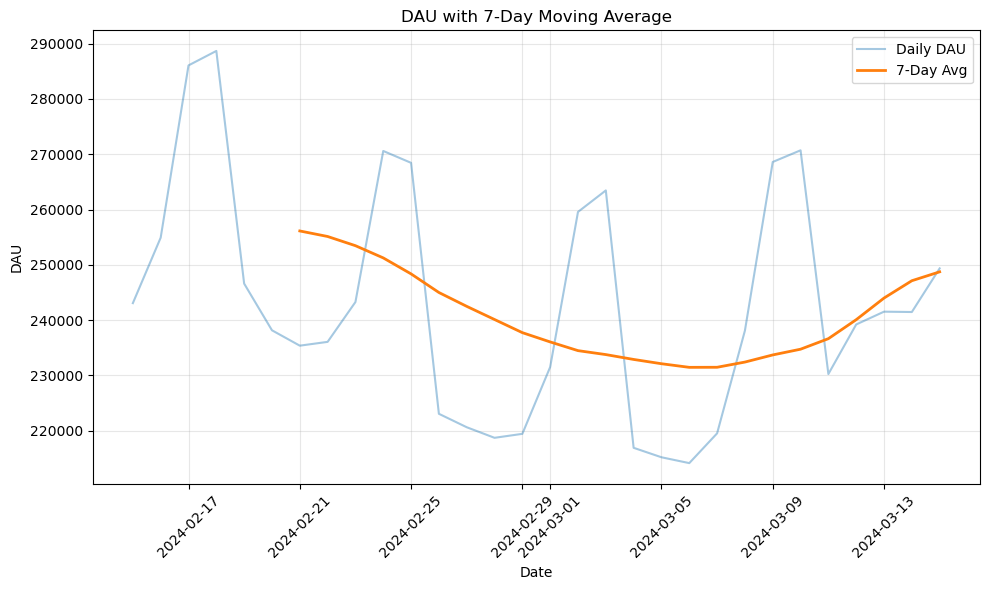

In [11]:
dau["DAU_7day_avg"] = dau["DAU"].rolling(7).mean()

plt.figure(figsize=(10, 6))

plt.plot(dau["event_date"], dau["DAU"], alpha=0.4, label="Daily DAU")
plt.plot(dau["event_date"], dau["DAU_7day_avg"], linewidth=2, label="7-Day Avg")

plt.xlabel("Date")
plt.ylabel("DAU")
plt.title("DAU with 7-Day Moving Average")

plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

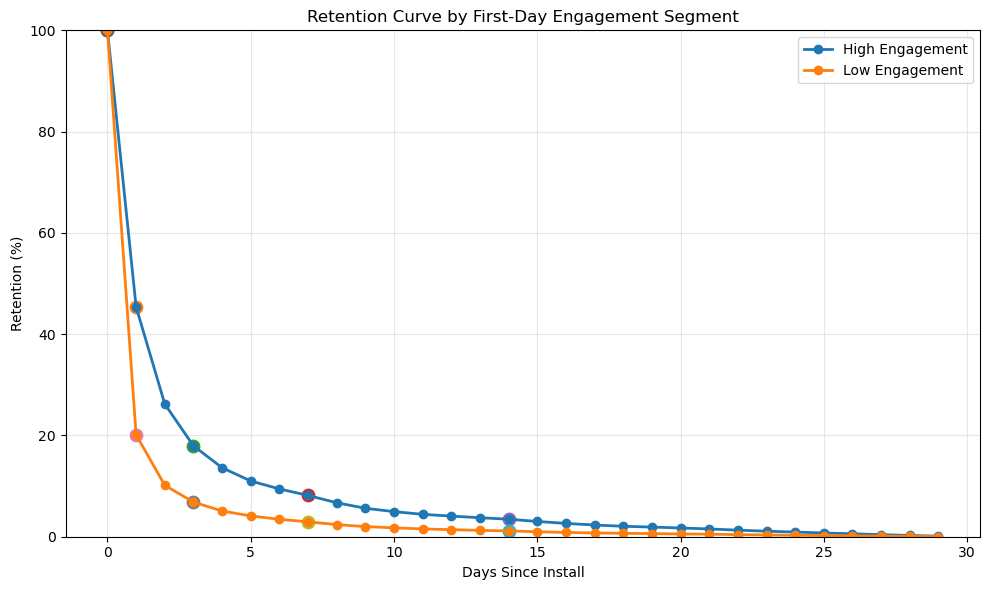

Total Revenue by Segment:
engagement_segment
High Engagement    192567.328077
Low Engagement      18027.050226
Name: total_revenue, dtype: float64

ARPU by Segment:
engagement_segment
High Engagement    0.364417
Low Engagement     0.034115
dtype: float64


In [12]:
day0 = df[df["days_since_install"] == 0]

first_day_engagement = (
    day0.groupby("user_id")
    .agg(
        sessions_day0=("total_session_count", "sum"),
        duration_day0=("total_session_duration", "sum"),
        matches_day0=("match_start_count", "sum"),
        iap_day0=("iap_revenue", "sum"),
        ad_day0=("ad_revenue", "sum")
    )
    .reset_index()
)

first_day_engagement["total_revenue_day0"] = (
        first_day_engagement["iap_day0"] +
        first_day_engagement["ad_day0"]
)


median_duration = first_day_engagement["duration_day0"].median()

first_day_engagement["engagement_segment"] = np.where(
    first_day_engagement["duration_day0"] > median_duration,
    "High Engagement",
    "Low Engagement"
)


df_segmented = df.merge(
    first_day_engagement[["user_id", "engagement_segment"]],
    on="user_id",
    how="left"
)


retention_segment = (
    df_segmented.groupby(["engagement_segment", "days_since_install"])["user_id"]
    .nunique()
    .reset_index()
    .rename(columns={"user_id": "active_users"})
)

cohort_segment = (
    df_segmented[df_segmented["days_since_install"] == 0]
    .groupby("engagement_segment")["user_id"]
    .nunique()
    .reset_index()
    .rename(columns={"user_id": "cohort_size"})
)

retention_segment = retention_segment.merge(
    cohort_segment,
    on="engagement_segment"
)

retention_segment["retention_rate"] = (
        retention_segment["active_users"] /
        retention_segment["cohort_size"]
)


plt.figure(figsize=(10, 6))

highlight_days = [0, 1, 3, 7, 14]

for segment in retention_segment["engagement_segment"].unique():

    subset = retention_segment[
        retention_segment["engagement_segment"] == segment
        ]

    plt.plot(
        subset["days_since_install"],
        subset["retention_rate"] * 100,
        marker="o",
        linewidth=2,
        label=segment
    )

    # Highlight key days
    for d in highlight_days:
        row = subset[
            subset["days_since_install"] == d
            ]

        if not row.empty:
            y = row["retention_rate"].values[0] * 100
            plt.scatter(d, y, s=80)

plt.xlabel("Days Since Install")
plt.ylabel("Retention (%)")
plt.title("Retention Curve by First-Day Engagement Segment")

plt.ylim(0, 100)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


df_segmented["total_revenue"] = (
        df_segmented["iap_revenue"] +
        df_segmented["ad_revenue"]
)

revenue_segment = (
    df_segmented.groupby("engagement_segment")["total_revenue"]
    .sum()
)

arpu_segment = (
        df_segmented.groupby("engagement_segment")["total_revenue"]
        .sum()
        /
        df_segmented.groupby("engagement_segment")["user_id"].nunique()
)

print("Total Revenue by Segment:")
print(revenue_segment)
print("\nARPU by Segment:")
print(arpu_segment)